In [1]:
import sys; sys.path += ['..']
from main_analysis import *

from glob import glob
import seaborn as sns
from torchinfo import summary

from plotnine import * # python's ggplot
import plotnine.options as plotnine_opts

In [2]:
benchmark = 'shared1000_OTC-only'
target_region = 'OTC'
benchmark = NSDBenchmark(*benchmark.split('_'))
image_paths = benchmark.stimulus_data.image_path

Now loading the shared1000 image set and the OTC-only voxel set...


### AlexNet Benchmarking Results

In [ ]:
model_string = 'alexnet_classification'
model_option = get_model_options()[model_string]
model_option['model_string'] = model_string
model_option['model'] = eval(model_option['call'])
model_option['transforms'] = get_recommended_transforms(model_string)

In [ ]:
image_path, image_transforms = benchmark.stimulus_data.image_path, model_option['transforms']
stimulus_loader = DataLoader(StimulusSet(image_path, image_transforms), batch_size = 64)

In [ ]:
feature_maps = get_all_feature_maps(model_option['model'], stimulus_loader)

In [ ]:
feature_maps_redux = get_feature_map_srps(feature_maps)

In [ ]:
precomputed_feature_maps = {'original': feature_maps,
                            'redux': feature_maps_redux}

In [ ]:
results = get_benchmarking_results(benchmark, model_option, precomputed_feature_maps)

In [ ]:
get_results_max(results['crsa'], average_over = ['subj_id']).query("region == @target_region")

In [ ]:
get_results_max(results['wrsa'], average_over = ['subj_id']).query("region == @target_region")

### AlexNet Effective Dimensionality

In [ ]:
from manifolds import ManifoldGeometry

def get_effective_dimensionality(representation):
    pca = PCA(random_state=0).fit(representation)
    eigenspectrum = pca.explained_variance_
    return eigenspectrum.sum() ** 2 / (eigenspectrum ** 2).sum()

In [ ]:
get_effective_dimensionality(feature_maps['Linear-1'])

In [ ]:
ManifoldGeometry(feature_maps['Linear-1']).dimensionality

In [ ]:
geometry_dictlist = []
for model_layer_index, model_layer in enumerate(tqdm(feature_maps)):
    geometry = get_effective_dimensionality(feature_maps[model_layer])
    geometry_redux = get_effective_dimensionality(feature_maps_redux[model_layer])
    geometry_dictlist.append({'model_layer': model_layer, 'model_layer_index': model_layer_index,
                              'effective_dimensions': geometry,
                              'effective_dimensions_redux': geometry_redux})
    
manifold_geometry = pd.DataFrame(geometry_dictlist)

In [ ]:
pearsonr(manifold_geometry.effective_dimensions, manifold_geometry.effective_dimensions_redux)

In [ ]:
geometry_dictlist = []
for model_layer_index, model_layer in enumerate(tqdm(feature_maps)):
    geometry = ManifoldGeometry(feature_maps[model_layer])
    geometry_redux = ManifoldGeometry(feature_maps_redux[model_layer])
    geometry_dictlist.append({'model_layer': model_layer, 'model_layer_index': model_layer_index,
                              'effective_dimensions': geometry.dimensionality,
                              'effective_dimensions_redux': geometry_redux.dimensionality})
    
manifold_geometry = pd.DataFrame(geometry_dictlist)

In [ ]:
results_combo = (results['wrsa'].merge(manifold_geometry, on = ['model_layer','model_layer_index'])
                 .groupby(['region','model_layer_index','model_layer'])
                 ['score','effective_dimensions', 'effective_dimensions_redux'].mean()).reset_index()

In [ ]:
results_combo.query('region == @target_region')

In [ ]:
plot_data = results_combo.query('region == @target_region')
sns.lmplot(data = plot_data, x = 'effective_dimensions', y = 'score');

### ResNet18 Effective Dimensionality

In [ ]:
model_string = 'resnet18_classification'
model_option = get_model_options()[model_string]
model = eval(model_option['call'])

image_transforms = get_recommended_transforms(model_string)
stimulus_loader = DataLoader(StimulusSet(image_paths, image_transforms), batch_size = 64)

In [ ]:
feature_maps = get_all_feature_maps(model, stimulus_loader)
feature_maps_redux = get_feature_map_srps(feature_maps)

In [ ]:
precomputed_feature_maps = {'original': feature_maps,
                            'redux': feature_maps_redux}

In [ ]:
results = get_benchmarking_results(benchmark, model_option, precomputed_feature_maps)

In [ ]:
def get_effective_dimensionality(representation):
    pca = PCA(random_state=0).fit(representation)
    eigenspectrum = pca.explained_variance_
    return eigenspectrum.sum() ** 2 / (eigenspectrum ** 2).sum()

geometry_dictlist = []
for model_layer_index, model_layer in enumerate(tqdm(feature_maps_redux)):
    geometry = get_effective_dimensionality(feature_maps_redux[model_layer])
    geometry_dictlist.append({'model_layer': model_layer, 'model_layer_index': model_layer_index,
                              'effective_dimensions': geometry})
    
manifold_geometry = pd.DataFrame(geometry_dictlist)

In [ ]:
plot_data = manifold_geometry[manifold_geometry['model_layer'].str.contains('ReLU')]
plot_data['model_layer_index'] = plot_data['model_layer'].str.split('-').str[-1]
sns.lineplot(data = plot_data, x = 'model_layer_index', y = 'effective_dimensions');

In [ ]:
results_combo = (results['wrsa'].merge(manifold_geometry, on = ['model_layer','model_layer_index'])
                 .groupby(['region','model_layer_index','model_layer'])
                 ['score','effective_dimensions'].mean()).reset_index()

In [ ]:
plot_data = results_combo[(results_combo['model_layer'].str.contains('ReLU')) &
                          (results_combo['region'] == target_region)]
sns.lmplot(data = plot_data, x = 'effective_dimensions', y = 'score');

### ResNet18 Double Check

In [3]:
from torch.nn import functional as F

In [4]:
benchmark = 'shared1000_OTC-only'
target_region = 'OTC'
benchmark = NSDBenchmark(*benchmark.split('_'))
image_paths = benchmark.stimulus_data.image_path

Now loading the shared1000 image set and the OTC-only voxel set...


In [5]:
model_string = 'resnet18_classification'
model_option = get_model_options()[model_string]
model = eval(model_option['call'])

In [6]:
summary(model, depth = 5, verbose = 0)

Layer (type:depth-idx)                   Param #
ResNet                                   --
├─Conv2d: 1-1                            9,408
├─BatchNorm2d: 1-2                       128
├─ReLU: 1-3                              --
├─MaxPool2d: 1-4                         --
├─Sequential: 1-5                        --
│    └─BasicBlock: 2-1                   --
│    │    └─Conv2d: 3-1                  36,864
│    │    └─BatchNorm2d: 3-2             128
│    │    └─ReLU: 3-3                    --
│    │    └─Conv2d: 3-4                  36,864
│    │    └─BatchNorm2d: 3-5             128
│    └─BasicBlock: 2-2                   --
│    │    └─Conv2d: 3-6                  36,864
│    │    └─BatchNorm2d: 3-7             128
│    │    └─ReLU: 3-8                    --
│    │    └─Conv2d: 3-9                  36,864
│    │    └─BatchNorm2d: 3-10            128
├─Sequential: 1-6                        --
│    └─BasicBlock: 2-3                   --
│    │    └─Conv2d: 3-11                 73,728

In [8]:
image_transforms = get_recommended_transforms(model_string)
image_loader = DataLoader(StimulusSet(image_paths, image_transforms), batch_size = 64)

target_layers = ['ReLU-' + str(x) for x in range(1, 16+1)] #post-Conv ReLUs

feature_maps = get_all_feature_maps(model, image_loader, flatten = False, 
                                    numpy = False, layers_to_retain = target_layers)

Feature Extraction (Batch):   0%|          | 0/16 [00:00<?, ?it/s]

In [9]:
pooled_feature_maps = {}
for model_layer, feature_map in feature_maps.items():
    pooled_feature_map = F.adaptive_max_pool2d(feature_map, 1).squeeze()
    print(model_layer,  pooled_feature_map.shape)
    pooled_feature_maps[model_layer] = pooled_feature_map

ReLU-1 torch.Size([1000, 64])
ReLU-2 torch.Size([1000, 64])
ReLU-3 torch.Size([1000, 64])
ReLU-4 torch.Size([1000, 64])
ReLU-5 torch.Size([1000, 64])
ReLU-6 torch.Size([1000, 128])
ReLU-7 torch.Size([1000, 128])
ReLU-8 torch.Size([1000, 128])
ReLU-9 torch.Size([1000, 128])
ReLU-10 torch.Size([1000, 256])
ReLU-11 torch.Size([1000, 256])
ReLU-12 torch.Size([1000, 256])
ReLU-13 torch.Size([1000, 256])
ReLU-14 torch.Size([1000, 512])
ReLU-15 torch.Size([1000, 512])
ReLU-16 torch.Size([1000, 512])


In [10]:
#double_check_data = []

In [11]:
def get_effective_dimensionality(representation):
    pca = PCA(random_state=0).fit(representation)
    eigenspectrum = pca.explained_variance_
    return eigenspectrum.sum() ** 2 / (eigenspectrum ** 2).sum()

geometry_dictlist = []
for model_layer_index, (model_layer, feature_map) in enumerate(tqdm(pooled_feature_maps.items())):
    geometry = get_effective_dimensionality(feature_map)
    geometry_dictlist.append({'model_layer': model_layer, 'model_layer_index': model_layer_index,
                              'effective_dimensions': geometry})
    
manifold_geometry = pd.DataFrame(geometry_dictlist)
manifold_geometry['dataset'] = 'NSD-Shared1000'

double_check_data.append(manifold_geometry)

  0%|          | 0/16 [00:00<?, ?it/s]

In [ ]:
mapping = {'x': 'model_layer_index', 'y': 'effective_dimensions', 'color': 'dataset'}

plotnine_opts.figure_size = (10, 5)

(ggplot(data = manifold_geometry, mapping = aes(**mapping)) +
 geom_line() + geom_point() + theme_minimal() + 
 labs(y = 'Effective Dimensionality', x = 'ResNet18 ReLU Layer Index', color = '')).draw();

In [15]:
image_paths = pd.Series(glob('../image_sets/imagenet1k-val-10k-imgs/*.JPEG'))
image_loader = DataLoader(StimulusSet(image_paths, image_transforms), batch_size = 64)

feature_maps = get_all_feature_maps(model, image_loader, numpy = False, flatten = False,
                                    layers_to_retain = target_layers)

pooled_feature_maps = {}
for model_layer, feature_map in feature_maps.items():
    pooled_feature_maps[model_layer] = F.adaptive_max_pool2d(feature_map, 1).squeeze()
    
del feature_maps

geometry_dictlist = []
for model_layer_index, (model_layer, feature_map) in enumerate(tqdm(pooled_feature_maps.items())):
    geometry = get_effective_dimensionality(feature_map)
    geometry_dictlist.append({'model_layer': model_layer, 'model_layer_index': model_layer_index,
                              'effective_dimensions': geometry})
    
manifold_geometry = pd.DataFrame(geometry_dictlist)
manifold_geometry['dataset'] = 'ImageNet1K-Val10000'

double_check_data.append(manifold_geometry)

Feature Extraction (Batch):   0%|          | 0/157 [00:00<?, ?it/s]

  0%|          | 0/16 [00:00<?, ?it/s]

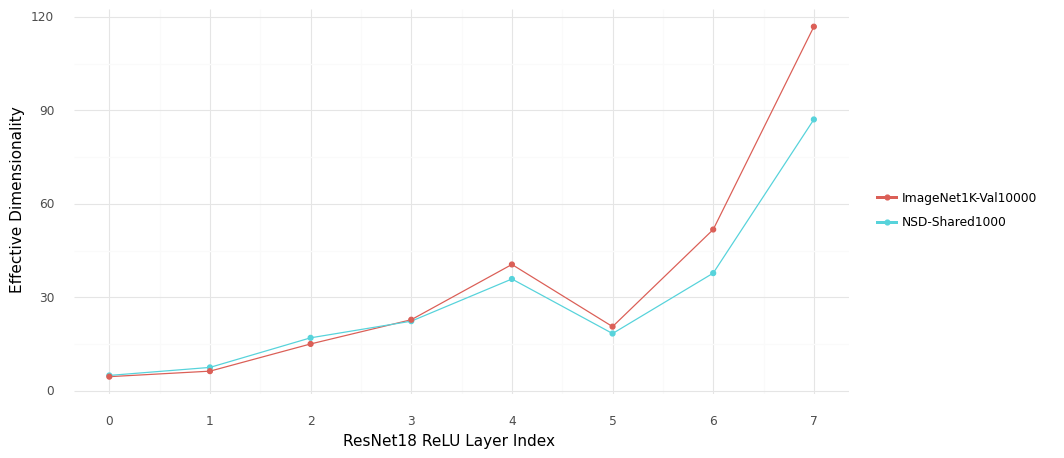

In [30]:
manifold_geometry = (pd.concat(double_check_data, axis = 0)
                     .query('model_layer_index % 2 == 1'))

manifold_geometry['model_layer_index'] = manifold_geometry['model_layer_index'] // 2

mapping = {'x': 'model_layer_index', 'y': 'effective_dimensions', 'color': 'dataset'}

plotnine_opts.figure_size = (10, 5)

(ggplot(data = manifold_geometry, mapping = aes(**mapping)) +
 geom_line() + geom_point() + theme_minimal() + scale_x_continuous(breaks = range(8)) +
 labs(y = 'Effective Dimensionality', x = 'ResNet18 ReLU Layer Index', color = '')).draw();

In [17]:
manifold_geometry.to_csv('../results_press/resnet18_effdims_check.csv', index = None)

### Effective Dimensionality across Models

In [ ]:
target_columns = ['model_string', 'model', 'train_task', 'train_data', 'architecture','metric','score']
results_summary = pd.read_csv('press_results/results_summary.csv')[target_columns]

In [ ]:
def reformat_model_string(model_string):
    if model_string == 'ViT-B-16_clip':
        model_string = 'ViT-B/16_clip'
    if model_string == 'ViT-B-32_clip':
        model_string = 'ViT-B/32_clip'
    if model_string == 'ViT-L-14_clip':
        model_string = 'ViT-L/14_clip'
    if '_imagenet' in model_string and 'ipcl' not in model_string:
        model_string = model_string.replace('_imagenet', '_classification')
    return model_string

In [ ]:
target_files = glob('fresh_results/manifold_stats/shared1000_OTC-only/*.csv')
manifold_stats = pd.concat([pd.read_csv(file) for file in target_files])
manifold_stats['model_string'] = (manifold_stats['model_string']
                                  .apply(lambda x: reformat_model_string(x)))

In [ ]:
'Number of unique models', len(manifold_stats.model_string.unique())

In [ ]:
plot_data = manifold_stats.merge(results_summary, on = ['model_string'])
plot_data = plot_data[~plot_data['train_task'].isin(['random'])]
plot_data = plot_data[plot_data['metric'].isin(['crsa','wrsa'])]
plot_data['effective_dimensions'] = np.log(plot_data['effective_dimensions'])
sns.lmplot(data = plot_data, x = 'effective_dimensions', y = 'score', 
           col = 'metric', row = 'random_projection')

In [ ]:
manifold_stats.to_csv('../results_press/manifold_stats.csv', index = None)